In [1]:
import numpy as np
import numpy
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
base_dir = '../data/'

In [4]:
full_df = pd.read_csv(base_dir+'train_1.csv', nrows=100)
dates = [c for c in full_df.columns if c !='Page']
val_dates = dates[-61:]
val = full_df[['Page']+val_dates]
train = full_df.drop(val_dates, axis=1)
filled_train = train.fillna(0)

In [5]:
X = filled_train.drop('Page', axis=1).values
y = val.fillna(0).drop('Page', axis=1).values

In [6]:
print(X.shape, y.shape)

(100, 489) (100, 61)


## Preprocessing
 * scale each time series to have 0 mean and unit variance

In [7]:
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
# discussion on which scaler to use here: https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/38274
# each ts should have 0 mean and unit variance
# since the time series are the 'features' being scaled, transpose first
X = scaler.fit_transform(X.T).T
print(X.shape)
assert(np.isclose(np.mean(X[0]),0))
# input shape: samples, timesteps, features
X = X.reshape(X.shape[0], X.shape[1], 1)
print(X.shape)
np.max(X)

(100, 489)
(100, 489, 1)


22.010761664611856

In [8]:
DEFAULT_SEED = 123456
n_pred = 60 # number of values to predict
n_cond = 60 # number of values to condition on

class DataProvider(object):
    """Generic data provider."""

    def __init__(self, inputs, targets, batch_size, max_num_batches=-1,
                 shuffle_order=True, rng=None):
        """Create a new data provider object.

        Args:
            inputs (ndarray): Array of data input features of shape
                (num_data, input_dim).
            targets (ndarray): Array of data output targets of shape
                (num_data, output_dim) or (num_data,) if output_dim == 1.
            batch_size (int): Number of data points to include in each batch.
            max_num_batches (int): Maximum number of batches to iterate over
                in an epoch. If `max_num_batches * batch_size > num_data` then
                only as many batches as the data can be split into will be
                used. If set to -1 all of the data will be used.
            shuffle_order (bool): Whether to randomly permute the order of
                the data before each epoch.
            rng (RandomState): A seeded random number generator.
        """
        self.inputs = inputs
        self.targets = targets
        if batch_size < 1:
            raise ValueError('batch_size must be >= 1')
        self._batch_size = batch_size
        if max_num_batches == 0 or max_num_batches < -1:
            raise ValueError('max_num_batches must be -1 or > 0')
        self._max_num_batches = max_num_batches
        self._update_num_batches()
        self.shuffle_order = shuffle_order
        self._current_order = np.arange(inputs.shape[0])
        if rng is None:
            rng = np.random.RandomState(DEFAULT_SEED)
        self.rng = rng
        self.new_epoch()

    @property
    def batch_size(self):
        """Number of data points to include in each batch."""
        return self._batch_size

    @batch_size.setter
    def batch_size(self, value):
        if value < 1:
            raise ValueError('batch_size must be >= 1')
        self._batch_size = value
        self._update_num_batches()

    @property
    def max_num_batches(self):
        """Maximum number of batches to iterate over in an epoch."""
        return self._max_num_batches

    @max_num_batches.setter
    def max_num_batches(self, value):
        if value == 0 or value < -1:
            raise ValueError('max_num_batches must be -1 or > 0')
        self._max_num_batches = value
        self._update_num_batches()

    def _update_num_batches(self):
        """Updates number of batches to iterate over."""
        # maximum possible number of batches is equal to number of whole times
        # batch_size divides in to the number of data points which can be
        # found using integer division
        possible_num_batches = self.inputs.shape[0] // self.batch_size
        if self.max_num_batches == -1:
            self.num_batches = possible_num_batches
        else:
            self.num_batches = min(self.max_num_batches, possible_num_batches)

    def __iter__(self):
        """Implements Python iterator interface.

        This should return an object implementing a `next` method which steps
        through a sequence returning one element at a time and raising
        `StopIteration` when at the end of the sequence. Here the object
        returned is the DataProvider itself.
        """
        return self

    def new_epoch(self):
        """Starts a new epoch (pass through data), possibly shuffling first."""
        self._curr_batch = 0
        if self.shuffle_order:
            self.shuffle()

    def reset(self):
        """Resets the provider to the initial state."""
        inv_perm = np.argsort(self._current_order)
        self._current_order = self._current_order[inv_perm]
        self.inputs = self.inputs[inv_perm]
        self.targets = self.targets[inv_perm]
        self.new_epoch()

    def shuffle(self):
        """Randomly shuffles order of data."""
        perm = self.rng.permutation(self.inputs.shape[0])
        self._current_order = self._current_order[perm]
        self.inputs = self.inputs[perm]
        self.targets = self.targets[perm]
        if hasattr(self, 'track_ids'):
            self.track_ids = self.track_ids[perm]

    def next(self):
        """Returns next data batch or raises `StopIteration` if at end."""
        if self._curr_batch + 1 > self.num_batches:
            # no more batches in current iteration through data set so start
            # new epoch ready for another pass and indicate iteration is at end
            self.new_epoch()
            raise StopIteration()
        # create an index slice corresponding to current batch number
        batch_slice = slice(self._curr_batch * self.batch_size,
                            (self._curr_batch + 1) * self.batch_size)
        inputs_batch = self.inputs[batch_slice]
        targets_batch = self.targets[batch_slice]
        self._curr_batch += 1
        return inputs_batch, targets_batch

    # Python 3.x compatibility
    def __next__(self):
        return self.next()
    
class MultiTSDataProvider(DataProvider):
    
    def __init__(self, which_set='train', batch_size=100, max_num_batches=-1,
                 shuffle_order=True, rng=None, n_pred=60, n_cond=60, stride_length=10,
                 scaler=StandardScaler(), base_dir = '../data/', n_ts=100):
        self.n_pred = n_pred # number of values to predict
        self.n_cond = n_cond # number of values on which to condition predictions
        full_df = pd.read_csv(base_dir+'train_1.csv')
        full_df = full_df.sample(n_ts, replace=False)
        dates = [c for c in full_df.columns if c !='Page']
        val_dates = dates[-(n_pred+n_cond):]
        self.val_dates = val_dates
        if which_set == 'train':
            inputs = full_df.drop(['Page'] + val_dates, axis=1).fillna(0).values
        elif which_set == 'val':
            inputs = full_df[val_dates].fillna(0).values
          # each ts should have 0 mean and unit variance
        if scaler:
            # need to change the way this behaves
            inputs = scaler.fit_transform(inputs)
            print(np.max(inputs))
        print(inputs.shape)
        
        if which_set == 'train':
            window_length = n_cond + n_pred
            n_windows = int(np.floor(np.divide(inputs.shape[1] - window_length,
                                               stride_length) + 1))
            start_index = 0
            window_array = np.ndarray((inputs.shape[0], n_windows, window_length))
            for i in range(n_windows):
                window_array[:,i,:] = inputs[:, start_index:start_index+window_length]
                start_index += stride_length
            print(window_array.shape)
            window_array = window_array.reshape((-1,window_length,1))
            print(window_array.shape)
            print('{} overlapping windows of length {} in training date range'.format(n_windows, window_length))
        #         inputs = w.reshape((-1, window_length, inputs.shape[-1])) # reshape inputs to (n_sample, length, n_features)
            targets = window_array[:,self.n_cond:,:] # shifted one along from inputs - so there is one target val which is never input, into either decoder or encoder
            inputs = np.pad(window_array[:,:-1,:],((0,0), (1,0), (0,0)),mode='constant')
            
        #         inputs, targets = inputs[:,:self.n_cond,:], inputs[:,self.n_cond:,:]
            inputs = inputs.reshape((inputs.shape[0], -1))
            targets = targets.reshape((targets.shape[0], -1))
        
        elif which_set == 'val':
            targets = inputs[:, self.n_cond:]
            inputs = np.pad(inputs[:,:self.n_cond], ((0,0), (1,n_pred-1)), mode='constant') # decoder inputs is now 1 useful num followed by a bunch of zeros, in principle
        
        print(inputs.shape, targets.shape)
        super(MultiTSDataProvider, self).__init__(
            inputs, targets, batch_size, max_num_batches, shuffle_order, rng)

In [9]:
train_data = MultiTSDataProvider(scaler=StandardScaler())
val_data = MultiTSDataProvider(scaler=StandardScaler(), which_set='val')
a = train_data.next()[0]
np.max(a)
inps, targs = val_data.next()

print('example validation decoder input: \n', inps[0][n_cond:],
      'example targets: \n', targs[0][:],
      'example inputs: \n', inps[0][:n_cond])

9.86570145996
(100, 430)
(100, 32, 120)
(3200, 120, 1)
32 overlapping windows of length 120 in training date range
(3200, 120) (3200, 60)
9.62122286284
(100, 120)
(100, 120) (100, 60)
example validation decoder input: 
 [-0.33158052  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] example targets: 
 [-0.3553055  -0.27947026 -0.31877014 -0.43816989 -0.42333603 -0.5669012
  0.31659855 -0.3226596

### Loss Function:

Modified SMAPE. Note that using MAE gives not much different results, but easier and faster to train, so I recommend MAE for starters. (https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/38337)

### Output:

You can predict one day, refit the model with previous days + predicted day, predict next day, etc, but it would be too slow and inefficient. The real power of RNN's is that you can build generative model, and predict all 60 days at once. (https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/38337)

ONLY PREDICT VALUES FOR A SINGLE TIME SERIES AT ONCE (c.f. the neural network eqn. 1 which outputs hidden rnn states for a single time series at a time, which are then combined to form the joint likelihood above) - DIFFERENT TIME SERIES ARE USED TO GENERATE DIFFERENT TRAINING EXAMPLES; SINGLE MODEL IS TRAINED ON ALL OF THEM.

a substantial amount
of data on past behavior of similar, related time series can be leveraged for making a forecast for an
individual time series. Using data from related time series not only allows fitting more complex (and
hence potentially more accurate) models without overfitting

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

Simplest model is probably some kind of ar

running predictions forward with keras: http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction, https://machinelearningmastery.com/how-to-use-an-encoder-decoder-lstm-to-echo-sequences-of-random-integers/. the crucial thing that makes sequence to sequence appropriate is: Information about the observations in the conditioning range zi,1:t0−1 is transferred to the prediction
range through the initial state hi,t0−1. In the sequence-to-sequence setup, this initial state is the output
of an encoder network. Also the two sequences may be of different lengths.

### Training examples
 
Secondly, due to the imbalance in the data, a stochastic optimization procedure that picks training
instances uniformly at random will visit the small number time series with a large scale very infrequently,
which result in underfitting those time series. This could be especially problematic in the
demand forecasting setting, where high-velocity items can exhibit qualitatively different behavior
than low-velocity items, and having an accurate forecast for high-velocity items might be more important
for meeting certain business objectives. To counteract this effect, we sample the examples
non-uniformly during training. In particular, in our weighted sampling scheme, the probability of
selecting a window from an example with scale νi is proportional to νi.

### Tensorflow seq2seq
[github seq2seq helpers](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/legacy_seq2seq/python/ops/seq2seq.py)
[ex. model built using above](https://github.com/tensorflow/models/blob/master/tutorials/rnn/translate/seq2seq_model.py)
[keras lib](https://github.com/farizrahman4u/seq2seq)
[new api (1.3) seq2seq](https://medium.com/@ilblackdragon/tensorflow-sequence-to-sequence-3d9d2e238084)
[seq2seq expts](https://github.com/raindeer/seq2seq_experiments/blob/master/model.py#L81)
* use tied_rnn_seq2seq if using tf
* will need to write custom loss func
* not sure the keras library will work because although we are sort of using encoder-decoder, we're not really outputting a 'context vector', just transferring the hidden state
* to pass predicted values in as inputs when decoding: https://stackoverflow.com/questions/38050333/how-to-predict-a-simple-sequence-using-seq2seq-from-tensorflow (although there is an option just to use the true values during training, which is what the amazon paper does).

The initial state
of the encoder hi,0 as well as zi,0 are initialized to zero

The basic rnn seq2seq works by making a copy of the cell (set of lstm units), and using two separate copies, one for encoder and one for decoder, with different weights. Tied rnn seq2seq  uses a single copy, ensuring weights are shared.

### Validation Data

Should be normalized in the same way as training data (i.e. using statistics from the training data). But this doesn't really make sense - there's no shared features. So phaps just normalize validation inputs (not targets) in the same way that training inputs are normalized.

The Amazon paper suggests scaling by the average value

$v_i = 1  + \sum_{t=0}^{t_0} z_{i,t}$

where $t_0$ is the last conditioning timestep: i.e. we normalize on the conditioning period

In [118]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq import tied_rnn_seq2seq

lstm_size = 100

def compute_next_input(output, i):
    p = tf.reshape(tf.matmul(output, weights), (-1,)) + bias
    return tf.reshape(p,(-1,1))

def decoder_init(input_list, n_pred):
    for i in range(n_pred):
        input_list.append(tf.placeholder(tf.float32, shape=[None,1], name="decoder{0}".format(i)))

graph = tf.Graph()
with graph.as_default():
    cell = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    encoder_inputs = []
    decoder_inputs = []
    targets = []
    for i in range(n_cond):
        # individual inputs are single numbers 
        encoder_inputs.append(tf.placeholder(tf.float32, shape=[None,1], name="encoder{0}".format(i)))
    for i in range(n_pred):
        decoder_inputs.append(tf.placeholder(tf.float32, shape=[None,1], name="decoder{0}".format(i)))
    for i in range(n_pred):
        targets.append(tf.placeholder(tf.float32, shape=[None], name="target{0}".format(i)))
    train = tf.placeholder(tf.bool)
    bias = tf.Variable(initial_value=1.0)
    weights = tf.Variable(tf.truncated_normal(
            [lstm_size, 1], stddev=2. / (lstm_size + 1)**0.5), 
        'weights')
    def looper(output, i):
        return tf.reshape(tf.reshape(tf.matmul(output, weights), (-1,)) + bias, (-1,1))
#     targets = [decoder_inputs[i+1] for i in range(len(decoder_inputs)-1)] # targets are next inputs
    # could use sthg like tf.cond: https://www.tensorflow.org/versions/r0.12/api_docs/python/control_flow_ops/control_flow_operations
    # to determine whether or not to use a loop function
    outputs, states = tied_rnn_seq2seq(encoder_inputs, decoder_inputs, cell, loop_function=looper)
#     outputs, states = tf.cond(train, lambda: tied_rnn_seq2seq(encoder_inputs, decoder_inputs, cell),
#                               lambda: tied_rnn_seq2seq(encoder_inputs, decoder_inputs, cell, loop_function=looper))
#     outputs, states = tf.contrib.legacy_seq2seq.tied_rnn_seq2seq(encoder_inputs, decoder_inputs, cell)
    # to do val, need to define a loop function
    # outputs is a list where each thing has shape (batch_size,n_lstm)
    # loop_function will need to apply a linear transform
    preds = []
    losses = []
    for output, target in zip(outputs, targets):
#         weights = tf.Variable(tf.ones([lstm_size,1]))
        pred = tf.reshape(tf.matmul(output, weights), (-1,)) + bias
        preds.append(pred) # each pred is shape [batch_size]
        losses.append(tf.reduce_mean(tf.abs(pred-target))) # error for a given output position averaged over the batch
    
    mae = tf.reduce_mean(losses) # compute error averaged over the timesteps (and batch samples)
#     mae = tf.metrics.mean_absolute_error(targets, outputs)
    train_step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(mae)
    init_op = tf.global_variables_initializer()

In [20]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq import tied_rnn_seq2seq
hidden_dim = 50
output_dim = 1
input_dim = 1
layers_stacked_count = 2
n_cond = 60
n_pred = 60
learning_rate = 0.007
lr_decay = 0.92 
momentum = 0.5

tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    train = tf.placeholder(tf.bool)
    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(n_cond)
    ]

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(n_pred)
    ]

    go_sym = tf.placeholder(tf.float32, shape=(None, output_dim), name="GO")

    # Give a "GO" token to the decoder. 
    # You might want to revise what is the appended value "+ enc_inp[:-1]". 
#     dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + [tf.zeros_like(v) for v in enc_inp[:-1]]
#     dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO")] + enc_inp[1:]
    dec_inp = [go_sym] + expected_sparse_output[:-1] # feed previous target as next input

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)

    # For reshaping the input and output dimensions of the seq2seq RNN: 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))

    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    def looper(output, i):
        return output_scale_factor * (tf.matmul(output, w_out) + b_out)

    dec_outputs, dec_memory = tf.cond(train, lambda: tied_rnn_seq2seq(enc_inp, dec_inp, cell),
                                      lambda: tied_rnn_seq2seq(enc_inp, dec_inp, cell, loop_function=looper))
    # but without the "norm" part of batch normalization hehe. 
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

In [ ]:
print('here')

In [21]:
with tf.variable_scope('Loss'):
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
#         output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        output_loss += tf.reduce_mean(tf.abs(_y - _Y)) # average loss across batch for single timestep
    loss = output_loss
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

saver = tf.train.Saver()

In [22]:
print('here')

here


In [ ]:
from utils import clock

In [ ]:
import time
import os
ts = int(time.time())
model_dir = 'checkpoints/{}-{}-{}'.format(ts, n_cond, n_pred)
os.mkdir(model_dir)
n_ts = 100000

stride_length = n_cond
train_data = MultiTSDataProvider(n_ts=n_ts, scaler=StandardScaler(),
                                 n_cond=n_cond, n_pred=n_pred)
val_data = MultiTSDataProvider(n_ts=n_ts, scaler=StandardScaler(), which_set='val',
                               n_cond=n_cond, n_pred=n_pred)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess.run(tf.global_variables_initializer()))
errs = []
epochs = 15
for e in range(epochs):
    running_error = 0.
    val_error = 0.
    mean_running_error = 0.
    with clock():
        for input_batch, target_batch in train_data:
        #     print(input_batch.shape, target_batch.shape)
            feed_dict = {train: True}
            # each decoder input is batch size x 1
            for i in range(n_cond):
                feed_dict[enc_inp[i].name] = input_batch[:,i].reshape(-1,1)
            feed_dict[go_sym] = input_batch[:, n_cond].reshape(-1,1)
            for i in range(n_pred):
                feed_dict[expected_sparse_output[i].name] = target_batch[:,i].reshape(-1,1)
            _, err = sess.run([train_op, loss], feed_dict=feed_dict)
            errs.append(err)
            mean_preds = np.mean(input_batch[:,:n_cond], axis=1).reshape(-1,1)
    #         print(mean_preds.shape, target_batch.shape)
            mean_errs = np.abs(mean_preds - target_batch)
    #         print(mean_errs.shape)
            batch_mean_err = np.sum(np.mean(mean_errs, axis=0))
            running_error += err
            mean_running_error += batch_mean_err
        running_error /= train_data.num_batches
        mean_running_error /= train_data.num_batches
        saver.save(sess, model_dir+'/model.ckpt'.format(ts), global_step=e+1)
    for input_batch, target_batch in val_data:
        feed_dict = {train: False}
        for i in range(n_cond):
            feed_dict[enc_inp[i].name] = input_batch[:,i].reshape(-1,1)
        for i in range(n_pred):
            feed_dict[expected_sparse_output[i].name] = target_batch[:,i].reshape(-1,1)
        feed_dict[go_sym] = input_batch[:, n_cond].reshape(-1,1)
        val_err = sess.run(loss, feed_dict=feed_dict)
        # this time we don't need to feed in either decoder_inputs or targets
        val_error += val_err
    val_error /= val_data.num_batches
    print("""End of epoch {0}: running error average = {1:.3f}\n
             mean error average = {2:.3f}\n
             val error average = {3:.3f}""".format(e + 1, running_error, mean_running_error, val_error))
# print(len(preds), preds[0])

255.034104714
(100000, 290)
(100000, 4, 260)
(400000, 260, 1)
4 overlapping windows of length 260 in training date range
(400000, 260) (400000, 60)
253.519151404
(100000, 260)
(100000, 260) (100000, 60)


KeyboardInterrupt: 

In [119]:
n_ts = 15000
train_data = MultiTSDataProvider(n_ts=n_ts, scaler=None)
val_data = MultiTSDataProvider(n_ts=n_ts, scaler=None, which_set='val')

sess = tf.Session(graph=graph_new)
sess.run(init_op)
errs = []
epochs = 15
for e in range(epochs):
    running_error = 0.
    val_error = 0.
    mean_running_error = 0.
    for input_batch, target_batch in train_data:
    #     print(input_batch.shape, target_batch.shape)
        feed_dict = {train: True}
        # each decoder input is batch size x 1
        for i in range(n_cond):
            feed_dict[encoder_inputs[i].name] = input_batch[:,i].reshape(-1,1)
#         for i in range(n_pred):
#             feed_dict[decoder_inputs[i].name] = input_batch[:,n_cond+i].reshape(-1,1)
        feed_dict[go_sym]
        for i in range(n_pred):
            feed_dict[targets[i].name] = target_batch[:,i]
        _, err, predictions = sess.run([train_step, mae, preds], feed_dict=feed_dict)
        errs.append(err)
        mean_preds = np.mean(input_batch[:,:n_cond], axis=1).reshape(-1,1)
#         print(mean_preds.shape, target_batch.shape)
        mean_errs = np.abs(mean_preds - target_batch)
#         print(mean_errs.shape)
        batch_mean_err = np.mean(mean_errs)
        running_error += err
        mean_running_error += batch_mean_err
    running_error /= train_data.num_batches
    mean_running_error /= train_data.num_batches
    for input_batch, target_batch in val_data:
        feed_dict = {train: False}
        for i in range(n_cond):
            feed_dict[encoder_inputs[i].name] = input_batch[:,i].reshape(-1,1)
        for i in range(n_pred):
            feed_dict[targets[i].name] = target_batch[:,i]
        for i in range(n_pred):
            feed_dict[decoder_inputs[i].name] = input_batch[:,n_cond+i].reshape(-1,1)
        val_err = sess.run(mae, feed_dict=feed_dict)
        # this time we don't need to feed in either decoder_inputs or targets
        val_error += val_err
    val_error /= val_data.num_batches
    print("""End of epoch {0}: running error average = {1:.3f}\n
             mean error average = {2:.3f}\n
             val error average = {3:.3f}""".format(e + 1, running_error, mean_running_error, val_error))
# print(len(preds), preds[0])

(10000, 430)
(10000, 32, 120)
(320000, 120, 1)
32 overlapping windows of length 120 in training date range
(320000, 120) (320000, 60)
(10000, 120)
(10000, 120) (10000, 60)
End of epoch 1: running error average = 2074.866

             mean error average = 762.788

             val error average = 2645.138
End of epoch 2: running error average = 2134.695

             mean error average = 762.788

             val error average = 2640.346
End of epoch 3: running error average = 2122.639

             mean error average = 762.788

             val error average = 2623.792


KeyboardInterrupt: 

14.1057073377
(200, 260)
(200, 260) (200, 60)


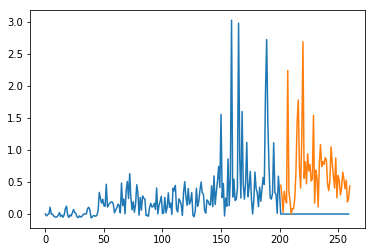

In [42]:
n_cond=200
val_data = MultiTSDataProvider(n_ts=200, scaler=StandardScaler(), which_set='val', n_cond=n_cond)
v_seq = val_data.inputs[190:,:]
v_targs = val_data.targets[190:,:]

single_s = v_seq[9,:]
single_ts = v_targs[9,:]

plt.plot(range(len(single_s)), single_s)
plt.plot([n_cond + 1 + i for i in range(len(single_ts))], single_ts)
# def predict_sequence(inputs, targets)

In [43]:
feed_dict = {train: False}
for i in range(n_cond):
    feed_dict[enc_inp[i].name] = v_seq[:,i].reshape(-1,1)
feed_dict[go_sym] = v_seq[:,n_cond].reshape(-1,1)
for i in range(n_pred):
    feed_dict[expected_sparse_output[i].name] = v_targs[:,i].reshape(-1,1)
pred_vals = sess.run(reshaped_outputs, feed_dict=feed_dict)

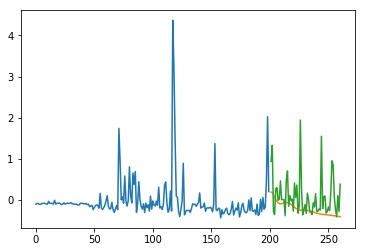

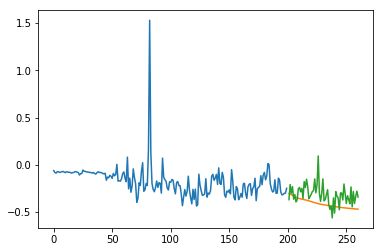

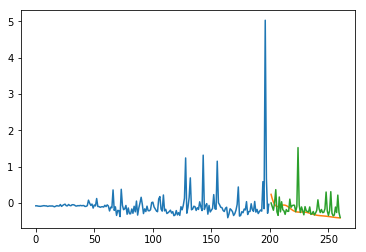

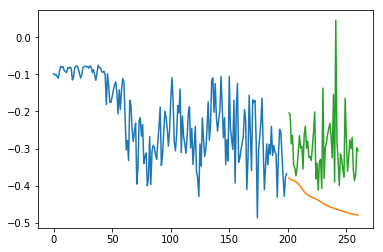

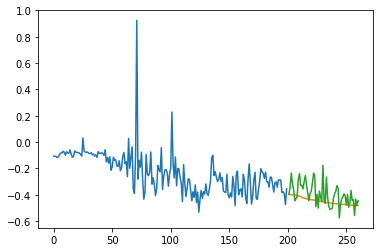

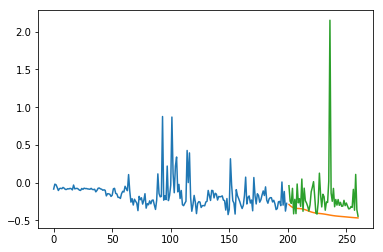

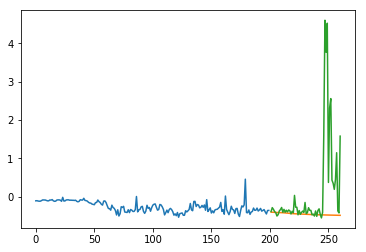

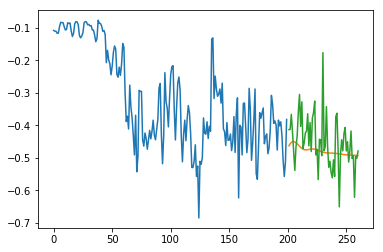

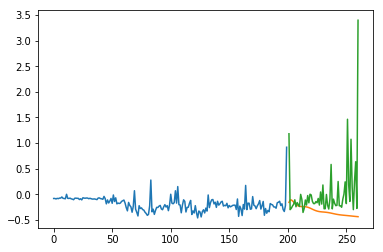

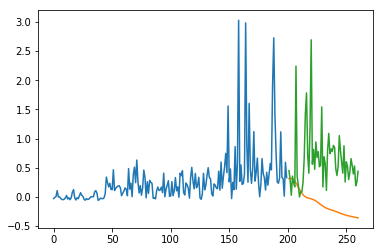

In [47]:
for i in range(10):
    fig = plt.figure()
    plt.plot([v_seq[i,j+1] for j in range(n_cond)])
    plt.plot([n_cond + 1 + i for i in range(n_pred)],[p[i] for p in pred_vals])
    plt.plot([n_cond + 1 + i for i in range(n_pred)],[v_targs[i,j] for j in range(n_pred)])

## Sanity check:

 * Look at (plot) trained model's predictions from a few out of training sample time series (compare plot after just training on one batch to after a full training run).

* Look at SMAPE on val set

(NOT GOOD IDEA: Plot multiple sets of predictions for a single time series to verify that the RNN is acting as a generative model in a sensible (random) way - NO THE CURRENT MODEL IS DETERMINISTIC, TO MAKE A PROBABILISTIC MODEL I WOULD HAVE TO OUTPUT PROBABILITIES/PARAMETERS OF A PROBABILITY DISTRIBUTION RATHER THAN ACTUAL VALUES.)

In [ ]:
val_data = MultiTSDataProvider(n_ts=200, scaler=None, which_set='val')

In [86]:
val_data.inputs.shape, val_data.targets.shape

((200, 120), (200, 60))

In [88]:
feed_dict = {train: False}
for i in range(n_cond):
    feed_dict[encoder_inputs[i].name] = v_seq[:,i].reshape(-1,1)
for i in range(n_pred):
    feed_dict[targets[i].name] = v_targs[:,i]
for i in range(n_pred):
    feed_dict[decoder_inputs[i].name] = v_seq[:,i].reshape(-1,1)
pred_err, pred_vals = sess.run([mae, preds], feed_dict=feed_dict)

In [90]:
[p[9] for p in pred_vals]

[29.966311,
 30.700642,
 30.565092,
 30.607529,
 30.699869,
 30.820126,
 30.955162,
 31.09614,
 31.237381,
 31.375389,
 31.508165,
 31.634653,
 31.754412,
 31.867376,
 31.973694,
 32.073643,
 32.167557,
 32.255798,
 32.338726,
 32.416702,
 32.490063,
 32.559128,
 32.62418,
 32.685505,
 32.743351,
 32.797951,
 32.849522,
 32.898258,
 32.944344,
 32.987946,
 33.029221,
 33.06831,
 33.10535,
 33.140461,
 33.173756,
 33.205341,
 33.235317,
 33.263775,
 33.290802,
 33.316467,
 33.340855,
 33.364029,
 33.386059,
 33.40699,
 33.426895,
 33.44582,
 33.463806,
 33.480904,
 33.497154,
 33.512589,
 33.527245,
 33.541161,
 33.554348,
 33.566845,
 33.578659,
 33.589825,
 33.600334,
 33.610199,
 33.619431,
 33.628021]

### Check what happens if I do feed decoder inputs, and I do  train.

In [62]:
d = pd.read_csv('~/Downloads/median_smapes.csv')
len(d)

145063

In [103]:
sess.run(weights)

array([[ 6.04784536],
       [-0.58076155],
       [ 5.3185668 ],
       [ 0.19689314],
       [ 6.33993053],
       [ 5.79123735],
       [-9.02900887],
       [ 0.57483214],
       [-6.69227028],
       [-5.93069601]], dtype=float32)

In [117]:
from tensorflow.contrib.legacy_seq2seq import basic_rnn_seq2seq
help(basic_rnn_seq2seq)

Help on function basic_rnn_seq2seq in module tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq:

basic_rnn_seq2seq(encoder_inputs, decoder_inputs, cell, dtype=tf.float32, scope=None)
    Basic RNN sequence-to-sequence model.
    
    This model first runs an RNN to encode encoder_inputs into a state vector,
    then runs decoder, initialized with the last encoder state, on decoder_inputs.
    Encoder and decoder use the same RNN cell type, but don't share parameters.
    
    Args:
      encoder_inputs: A list of 2D Tensors [batch_size x input_size].
      decoder_inputs: A list of 2D Tensors [batch_size x input_size].
      cell: tf.nn.rnn_cell.RNNCell defining the cell function and size.
      dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
      scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
    
    Returns:
      A tuple of the form (outputs, state), where:
        outputs: A list of the same length as decoder_inputs of